In [1]:
from pylab import *
import h5py
from scipy.optimize import curve_fit
#from scipy.stats import binned_statistic_dd
from lib.analysis_library import vectorized_binned_statistic_dd
import filter_masks
import pickle
from scipy import stats

In [2]:
def t_func(r,median_truncation):
	try:
		temp = np.array([pickle.loads(i) for i in r])
	
		x=temp[:,0]
		y=temp[:,1]


		myLength=len(y)
		threshold=median_truncation/400.0
		ySortedIndex = np.argsort(y)
		y = y[ySortedIndex][int(threshold*myLength):int(myLength*(1-1*threshold))]
		x = x[ySortedIndex][int(threshold*myLength):int(myLength*(1-1*threshold))]
	
		xSortedIndex = np.argsort(x)
		y = y[xSortedIndex][int(threshold*myLength):int(myLength*(1-1*threshold))]
		x = x[xSortedIndex][int(threshold*myLength):int(myLength*(1-1*threshold))]

	
		myCov = np.cov(x,y)
		simple_slope = myCov[0,1]/myCov[0,0]
	
		non_serialized_result = np.array([np.mean(y*1.0/x),np.mean(y)/np.mean(1.0*x),simple_slope])
		#serialized_result = pickle.dumps(non_serialized_result)
		dict_result = {'shot_by_shot_median':np.median(y*1.0/x),'shot_by_shot_average':np.mean(y*1.0/x),'median':np.median(y)/np.median(1.0*x),'average':np.mean(y)/np.mean(1.0*x),'slope':simple_slope}
	except:
		dict_result = {'shot_by_shot_median':-9999.0,'shot_by_shot_average':-9999.0,'median':-9999.0,'average':-9999.0,'slope':-9999.0}

	return dict_result

In [3]:
#load data
experiment_run_name = "sxri0414run72"
my_file = experiment_run_name+".h5"
my_hdf5_object = h5py.File("small_h5_data/"+my_file,"r")

In [4]:
#convert hdf5 to dict
my_list = []
def func(name, obj):
    my_list.append(name)

my_hdf5_object.visititems(func)
my_dict = {}
for i in my_list:
    my_dict[i] = array(my_hdf5_object[i])

In [5]:
#configuration parameters
time_tool_sign = 1
pixel_to_femtosecond = 0.0033444
delay_stage_offset = min(my_dict['delayStage'])

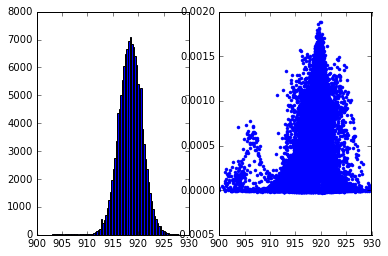

In [6]:
subplot(121)
hist(my_dict['ebeam/photon_energy'],bins=arange(900,930,0.3))
subplot(122)
plot(my_dict['ebeam/photon_energy'],my_dict['GMD'],'.')
xlim(900,930)
show()

In [7]:
#make mask
my_mask =  filter_masks.__dict__[experiment_run_name](my_dict)
my_mask *=  (my_dict['timeToolOpal/time_pixel']>200)
my_mask *=  (my_dict['timeToolOpal/time_pixel']<500)
my_mask *=  (my_dict['ebeam/photon_energy']<922)
my_mask *=  (my_dict['ebeam/photon_energy']>912)

/reg/data/ana13/sxr/sxri0414/res/automated_analysis/filter_masks.py:75: RuntimeWarning: invalid value encountered in greater
  myMask = myMask * (array(myDict['gas_detector/f_11_ENRC'])>0.3)


In [8]:
my_dict['corrected_time'] = (2/.3*(my_dict['delayStage']-delay_stage_offset)+time_tool_sign*(my_dict['TSS_OPAL/pixelTime']-mean(my_dict['TSS_OPAL/pixelTime'][my_mask]))*pixel_to_femtosecond )

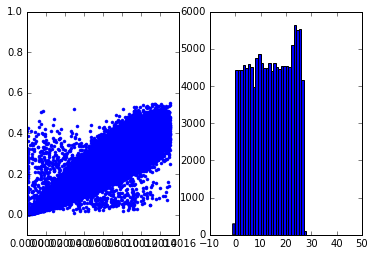

In [9]:
subplot(121)
plot(my_dict['GMD'][my_mask],my_dict['acqiris2/amplitude'][my_mask],'.')
ylim(-0.1,1)
subplot(122)
hist(my_dict['corrected_time'],bins=arange(-1,50))
show()

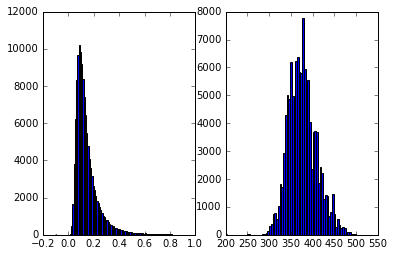

In [10]:
subplot(121)
hist(abs(my_dict['timeToolOpal/uncertainty_cov'])**0.5,bins=arange(-0.1,1,0.01))
subplot(122)
hist(abs(my_dict['timeToolOpal/time_pixel']),bins=arange(200,550,4))
show()

In [11]:
truncation_value = 0.05
def t_func_wrapper(r):
	return t_func(r,truncation_value)
x = my_dict['GMD'][my_mask]
y = my_dict['acqiris2/amplitude'][my_mask]
z = my_dict['corrected_time'][my_mask]
myValues = array([x,y]).transpose()
my_bins = arange(-5,30,0.2)

In [12]:
my_results = vectorized_binned_statistic_dd(z,myValues,bins=[my_bins],statistic=t_func_wrapper)

/reg/g/psdm/sw/conda/inst/miniconda2-prod-rhel7/envs/ana-1.2.9-py3/lib/python3.5/site-packages/numpy/lib/function_base.py:2487: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)
/reg/g/psdm/sw/conda/inst/miniconda2-prod-rhel7/envs/ana-1.2.9-py3/lib/python3.5/site-packages/numpy/lib/function_base.py:2496: RuntimeWarning: divide by zero encountered in double_scalars
  c *= 1. / np.float64(fact)
/reg/g/psdm/sw/conda/inst/miniconda2-prod-rhel7/envs/ana-1.2.9-py3/lib/python3.5/site-packages/numpy/lib/function_base.py:2496: RuntimeWarning: invalid value encountered in multiply
  c *= 1. / np.float64(fact)


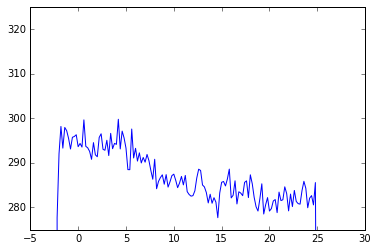

In [13]:
plot(my_bins[:-1],my_results['average'][::-1])
#ylim(max(my_results['average'])*0.9,max(my_results['average'])*1.01)
ylim(275,325)
#xlim(4,26)
show()